## LSTM Time-Series Prediction

The goal here is to predict upcoming passenger counts for an airline based on historical data. This is a time-series prediction problem, so we will use a Long Short-Term Memory (LSTM) recurrent neural network for our analysis.  We will use a 4 day window for our time steps. By that, I mean we will use the data from the previous 4 days to predict the passenger count for the next day in a rolling wave. The passenger numbers are in units of 1,000.

In [1]:
import pandas as pd
import numpy as np
from numpy import array
import random as rn
import tensorflow as tf
from tensorflow import set_random_seed
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional
from keras import regularizers
from keras.optimizers import Adam
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [2]:
# set the random seed
sd = 777
np.random.seed(sd)
rn.seed(sd)
set_random_seed(sd)

In [3]:
# load the dataset
series = pd.read_csv('data/airline-passengers.csv', usecols=[1], engine='python')
series.head(10)

,Passengers
0,112
1,118
2,132
3,129
4,121
5,135
6,148
7,148
8,136
9,119


Input data shape: (144, 1)


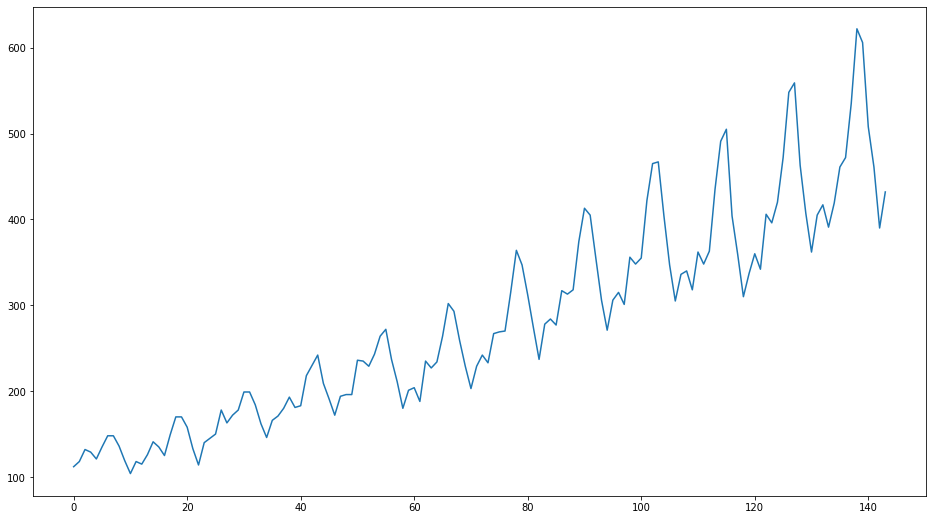

In [4]:
 # review dataset & extract values
data = series.values
data = data.astype('float64')
print("Input data shape:", data.shape)
plt.subplots(figsize=(16,9))
plt.plot(data)
plt.show()

In [5]:
# normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)
print("The scaled dataset shape is:", data_scaled.shape)
print(data_scaled)

The scaled dataset shape is: (144, 1)
[[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984556]
 [0.08494208]
 [0.08494208]
 [0.06177606]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123552]
 [0.04247104]
 [0.07142857]
 [0.05984556]
 [0.04054054]
 [0.08687259]
 [0.12741313]
 [0.12741313]
 [0.1042471 ]
 [0.05598456]
 [0.01930502]
 [0.06949807]
 [0.07915058]
 [0.08880309]
 [0.14285714]
 [0.11389961]
 [0.13127413]
 [0.14285714]
 [0.18339768]
 [0.18339768]
 [0.15444015]
 [0.11196911]
 [0.08108108]
 [0.11969112]
 [0.12934363]
 [0.14671815]
 [0.17181467]
 [0.14864865]
 [0.15250965]
 [0.22007722]
 [0.24324324]
 [0.26640927]
 [0.2027027 ]
 [0.16795367]
 [0.13127413]
 [0.17374517]
 [0.17760618]
 [0.17760618]
 [0.25482625]
 [0.25289575]
 [0.24131274]
 [0.26833977]
 [0.30888031]
 [0.32432432]
 [0.25675676]
 [0.20656371]
 [0.14671815]
 [0.18725869]
 [0.19305019]
 [0.16216216]
 [0.25289575]
 [0.23745174]
 [0.25096525]
 [0.30888031]
 [0.38223938]
 [0.36486486]
 [0.299227

In [6]:
# split into training and test sets
test_size = 24
train = data_scaled[:-test_size, : ]
test = data_scaled[-test_size:, :]
print("Training set size:", len(train))
print("Test set size:", len(test))

Training set size: 120
Test set size: 24


In [7]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, n_steps):
    dataX, dataY = [], []
    for i in range(len(dataset)-n_steps-1):
        a = dataset[i:(i+n_steps), 0]
        dataX.append(a)
        dataY.append(dataset[i + n_steps, 0])
    return np.array(dataX), np.array(dataY)

In [9]:
# split data into input / output groups
n_steps = 4
X_train, y_train = split_sequences(train, n_steps)
X_test, y_test = split_sequences(test, n_steps)
print("Training input shape:", X_train.shape)
print("Training output shape:", y_train.shape)
print("Test input shape:", X_test.shape)
print("Test output shape:", y_test.shape)
for i in range(4):
    print(X_train[i], y_train[i])

Training input shape: (116, 4, 1)
Training output shape: (116, 1)
Test input shape: (20, 4, 1)
Test output shape: (20, 1)
[[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]] [0.03281853]
[[0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]] [0.05984556]
[[0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984556]] [0.08494208]
[[0.04826255]
 [0.03281853]
 [0.05984556]
 [0.08494208]] [0.08494208]


In [12]:
# define the LSTM model
def lstm_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(10, activity_regularizer=regularizers.l1(10e-4))(inputs)
    output = Dense(1)(L1)
    model = Model(inputs=inputs, outputs=output)
    return model    

In [13]:
# create the LSTM model
batch_size = 5
model = lstm_model(X_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fit the model
nb_epochs = 1000
history = model.fit(X_train, y_train, epochs=nb_epochs, batch_size=batch_size, shuffle=False, validation_data=(X_test, y_test), verbose=0).history

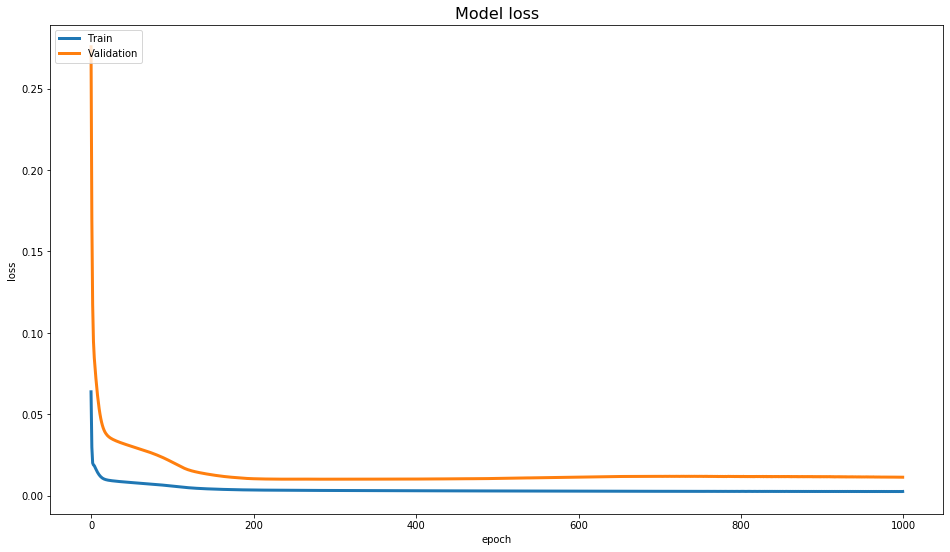

In [15]:
# plot the model loss
fig, axis2 = plt.subplots(figsize=(16,9))
axis2.plot(history["loss"], label='Train', linewidth=3)
axis2.plot(history["val_loss"], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper left')
plt.show()

In [16]:
# make predictions
trainPredict = model.predict(X_train, batch_size)
testPredict = model.predict(X_test, batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

In [17]:
trainY = scaler.inverse_transform(y_train)
true_values = scaler.inverse_transform(y_test)

In [18]:
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(trainY[115], trainPredict[115]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(true_values[19], testPredict[19]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 3.41 RMSE
Test Score: 14.41 RMSE


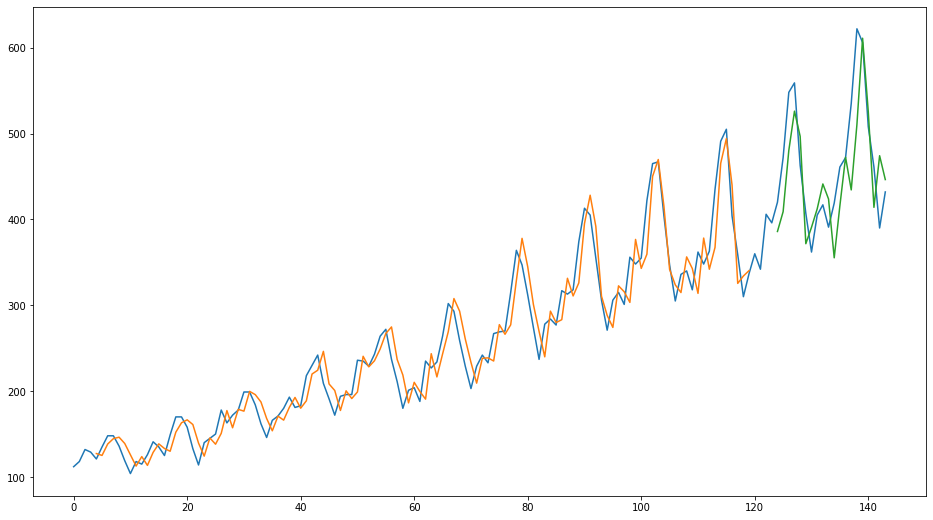

In [19]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[n_steps:len(trainPredict)+n_steps, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(n_steps*2):len(data), :] = testPredict
# plot baseline and predictions
plt.subplots(figsize=(16,9))
plt.plot(data)
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()